一、任务说明

本文件代码用于展现使用ResNet101局部表示+LSTM+注意力机制模型、采用束搜索策略生成图像描述的过程。

二、实验数据

随机选择测试集下图片进行束搜索验证模型功能。

三、实验环境


硬件要求： CPU或支持GPU加速的硬件设备，如NVIDIA GPU，用于加速深度学习模型的训练和推理。

操作系统：Windows10

编写环境：jupyter notebook

深度学习框架：依赖于深度学习框架PyTorch


In [16]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.backends.cudnn as cudnn
import numpy as np
from nltk.translate.bleu_score import corpus_bleu
from tqdm import tqdm
from datasets import *
from utils import *
import os 
from getdata import words

In [56]:
# 通过将目录路径与目录中的每个文件结合，创建文件路径列表
# 从列表中选择第5624个文件路径（在从零开始的索引中是第5623个）
path = r'C:\Users\chubby\Desktop\code\images'
base = [os.path.join(path,i) for i in os.listdir(path)][5623]

word_map = words(r'C:\Users\chubby\Desktop\训练测试划分\train_captions.json')


In [57]:
# Hyperparameters
image_path = base
#checkpoint = '/data3/zhangweiyi/coco2014/BEST_checkpoint_coco_5_cap_per_img_5_min_word_freq.pth.tar'
checkpoint = 'checkpoint_DeepFashion_MultiModal.pth.tar'
beam_size = 5 # Beam 搜索的大小
smooth = True # 是否使用平滑化处理
attention = True # 是否使用注意力机制
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

四、所用的方法

1、加载训练好的模型

In [58]:
# Load model
checkpoint = torch.load(checkpoint, map_location=str(device))# 从检查点文件加载模型参数
encoder = checkpoint['encoder'] # 从检查点中获取编码器
encoder = encoder.to(device) # 将编码器移动到选择的设备（GPU或CPU）
encoder.eval() # 设置编码器为评估模式（不进行梯度计算）
decoder = checkpoint['decoder'] # 从检查点中获取解码器
decoder = decoder.to(device) # 将解码器移动到选择的设备（GPU或CPU）
decoder.eval()# 设置解码器为评估模式（不进行梯度计算）

DecoderWithAttention(
  (attention): Attention(
    (encoded_linear): Linear(in_features=2048, out_features=256, bias=True)
    (decoder_linear): Linear(in_features=256, out_features=256, bias=True)
    (f_att): Linear(in_features=256, out_features=1, bias=True)
    (softmax): Softmax(dim=1)
    (relu): ReLU()
  )
  (embedding): Embedding(113, 256)
  (dropout_layer): Dropout(p=0.5, inplace=False)
  (decode_step): LSTMCell(2304, 256)
  (init_h): Linear(in_features=2048, out_features=256, bias=True)
  (init_c): Linear(in_features=2048, out_features=256, bias=True)
  (beta): Linear(in_features=256, out_features=2048, bias=True)
  (fc): Linear(in_features=256, out_features=113, bias=True)
  (sigmoid): Sigmoid()
  (active): Softmax(dim=None)
)

In [59]:
# Load word map (word2ix)

rev_word_map = {v: k for k, v in word_map.items()}  # ix2word
# 加载单词映射（word2ix）

# 创建一个将索引映射回单词的字典这里的 word_map 应该是一个字典，其中键是单词，
#值是对应的索引。然后，rev_word_map 被创建为一个反转的字典，将索引映射回单词。
#这在生成模型输出时用于将模型生成的索引转换为实际的单词。确保 word_map 的结构满足这个假设。

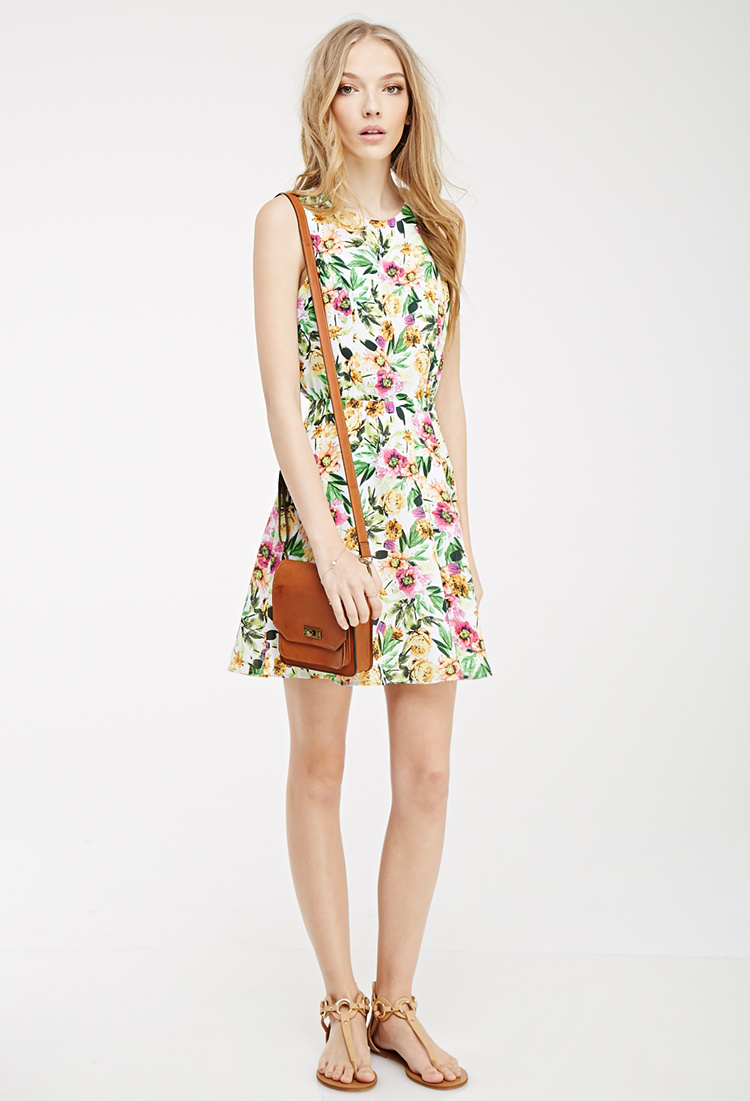

In [60]:
image = Image.open(image_path)
image

In [61]:
image = Image.open(image_path)

tx = transforms.Compose([
        transforms.Resize(256),
        transforms.RandomCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

image = tx(image).unsqueeze(0).to(device)
image.shape
#这里使用了 PyTorch 的 transforms 模块，它提供了一组用于图像预处理的工具。
#图像首先被调整大小，然后进行随机裁剪，最后被转换为张量并进行归一化。
#最终，图像被扩展为包含一个样本的张量，形状为 (1, 3, 224, 224)。

torch.Size([1, 3, 224, 224])

In [62]:
# Encode
encoder_out = encoder(image)

2、束搜索选择生成句子

（1）原理：

束搜索是一种用于生成序列的搜索策略，通常应用于序列生成任务，如机器翻译和图像标注。在图像标注任务中，模型生成描述图像内容的句子。束搜索通过在生成过程中保留多个备选序列，从而选择最有可能的序列。在每个时间步，它保留前 k 个可能的下一个单词，称为 "束宽"（beam width），并继续扩展这些备选序列。最终，从这些备选序列中选择得分最高的作为最终生成的序列。

（2）好处：

①多样性： 允许模型生成多个可能的序列，增加了生成结果的多样性。

②全局优化： 能够在生成整个序列时考虑全局信息，而非仅仅关注每一步的局部最优。

（3）不足：

①计算开销： 随着束宽的增加，计算开销呈指数增长。较大的束宽可能会导致生成速度变慢。

②局部最优： 由于每个时间步只考虑了前 k 个备选，束搜索可能陷入局部最优解，无法全局优化。

③过度保守： 由于束搜索在生成时偏向于保守的选择，可能会导致生成的句子过于普遍，缺乏一些创新性。


In [63]:
#这段代码执行了一个带有注意力机制的束搜索解码过程，生成图像的描述序列。

k = beam_size# Beam搜索的大小
vocab_size = len(word_map) # 词汇表大小


# 初始化数据结构，用于存储 top k 的前一个单词、序列、分数和注意力权重
# Tensor to store top k previous words at each step; now they're just <start>
k_prev_words = torch.LongTensor([[word_map['<start>']]] * k).to(device)  # (k, 1)

# Tensor to store top k sequences; now they're just <start>
seqs = k_prev_words  # (k, 1)

# Tensor to store top k sequences' scores; now they're just 0
top_k_scores = torch.zeros(k, 1).to(device)  # (k, 1)

# Encode
encoder_out = encoder(image)  # (1, enc_image_size, enc_image_size, encoder_dim) 


enc_image_size = encoder_out.size(1)
encoder_dim = encoder_out.size(3)
encoder_out = encoder_out.view(1, -1, encoder_dim)  # (1, num_pixels, encoder_dim)
num_pixels = encoder_out.size(1)
encoder_out = encoder_out.expand(k, num_pixels, encoder_dim)  # (k, num_pixels, encoder_dim)
# Tensor to store top k sequences' alphas; now they're just 1s
seqs_alpha = torch.ones(k, 1, enc_image_size, enc_image_size).to(device)  # (k, 1, enc_image_size, enc_image_size)

# 存储已完成序列、分数和注意力权重的列表
# Lists to store completed sequences, their alphas and scores
complete_seqs = list()
complete_seqs_scores = list()

complete_seqs_alpha = list()


# Start decoding
step = 1

mean_encoder_out = encoder_out.mean(dim=1)
h = decoder.init_h(mean_encoder_out)  # (1, decoder_dim)
c = decoder.init_c(mean_encoder_out)

smoth_wrong = False
# 在生成序列的过程中进行迭代
# s is a number less than or equal to k, because sequences are removed from this process once they hit <end>
while True:

     # 获取前一个步骤的嵌入表示
    embeddings = decoder.embedding(k_prev_words).squeeze(1)  # (s, embed_dim)
 
       # 执行解码器的一个时间步
    scores, alpha, h, c = decoder.one_step(embeddings, encoder_out, h, c)
    alpha = alpha.view(-1, enc_image_size, enc_image_size)

     # 对分数进行 log_softmax 处理
    scores = F.log_softmax(scores, dim=1)
    scores = top_k_scores.expand_as(scores) + scores  # (s, vocab_size)

     # 对于第一步，所有 k 个点将具有相同的分数（因为相同的 k 个前一个单词，h，c）
    # For the first step, all k points will have the same scores (since same k previous words, h, c)
    if step == 1:
        top_k_scores, top_k_words = scores[0].topk(k, 0, True, True)  # (s)
    else:
        # 展开并找到 top 分数及其展开的索引
        # Unroll and find top scores, and their unrolled indices
        top_k_scores, top_k_words = scores.view(-1).topk(k, 0, True, True)  # (s)

        # 将展开的索引转换为实际分数的索引
    # Convert unrolled indices to actual indices of scores
    prev_word_inds = top_k_words // vocab_size  # (s)
    next_word_inds = top_k_words % vocab_size  # (s)

     # 将新单词添加到序列和注意力权重中
    # Add new words to sequences, alphas
    seqs = torch.cat([seqs[prev_word_inds], next_word_inds.unsqueeze(1)], dim=1)  # (s, step+1)

    seqs_alpha = torch.cat([seqs_alpha[prev_word_inds], alpha[prev_word_inds].unsqueeze(1)],
                                dim=1)  # (s, step+1, enc_image_size, enc_image_size)

     # 找出哪些序列是不完整的（没有达到 <end>）
    # Which sequences are incomplete (didn't reach <end>)?
    incomplete_inds = [ind for ind, next_word in enumerate(next_word_inds) if
                       next_word != word_map['<end>']]
    complete_inds = list(set(range(len(next_word_inds))) - set(incomplete_inds))

    # 存储已完成的序列
    # Set aside complete sequences
    if len(complete_inds) > 0:
        complete_seqs.extend(seqs[complete_inds].tolist())
        complete_seqs_scores.extend(top_k_scores[complete_inds])
        if attention:
            complete_seqs_alpha.extend(seqs_alpha[complete_inds].tolist())
    # 减小束搜索长度    
    k -= len(complete_inds)  # reduce beam length accordingly

     # 继续处理不完整的序列
    # Proceed with incomplete sequences
    if k == 0:
        break
    seqs = seqs[incomplete_inds]

    seqs_alpha = seqs_alpha[incomplete_inds]
    h = h[prev_word_inds[incomplete_inds]]
    c = c[prev_word_inds[incomplete_inds]]
    encoder_out = encoder_out[prev_word_inds[incomplete_inds]]
    top_k_scores = top_k_scores[incomplete_inds].unsqueeze(1)
    k_prev_words = next_word_inds[incomplete_inds].unsqueeze(1)

    # 如果执行步骤过长，中断循环
    # Break if things have been going on too long
    if step > 150:
        smoth_wrong = True
        break
    step += 1
# 如果没有出现中断，选择分数最高的完成序列
if not smoth_wrong:
    i = complete_seqs_scores.index(max(complete_seqs_scores))
    seq = complete_seqs[i]

    alphas = complete_seqs_alpha[i]
    alphas = torch.FloatTensor(alphas)
else:
    # 如果中断了，选择第一个不完整序列并截取前20个单词
    seq = seqs[0][:20]

    alphas = complete_seqs_alpha[0]
    alphas = torch.FloatTensor(alphas)

C:\Users\chubby\AppData\Local\Temp\ipykernel_6368\1719405423.py:61: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  prev_word_inds = top_k_words // vocab_size  # (s)


五、实验结果

The person is wearing a sleeveless tank top with graphic patterns . The tank top is with cotton fabric . It has a crew neckline . The person wears a long pants . The pants are with cotton fabric and graphic patterns . There is an accessory on her wrist .


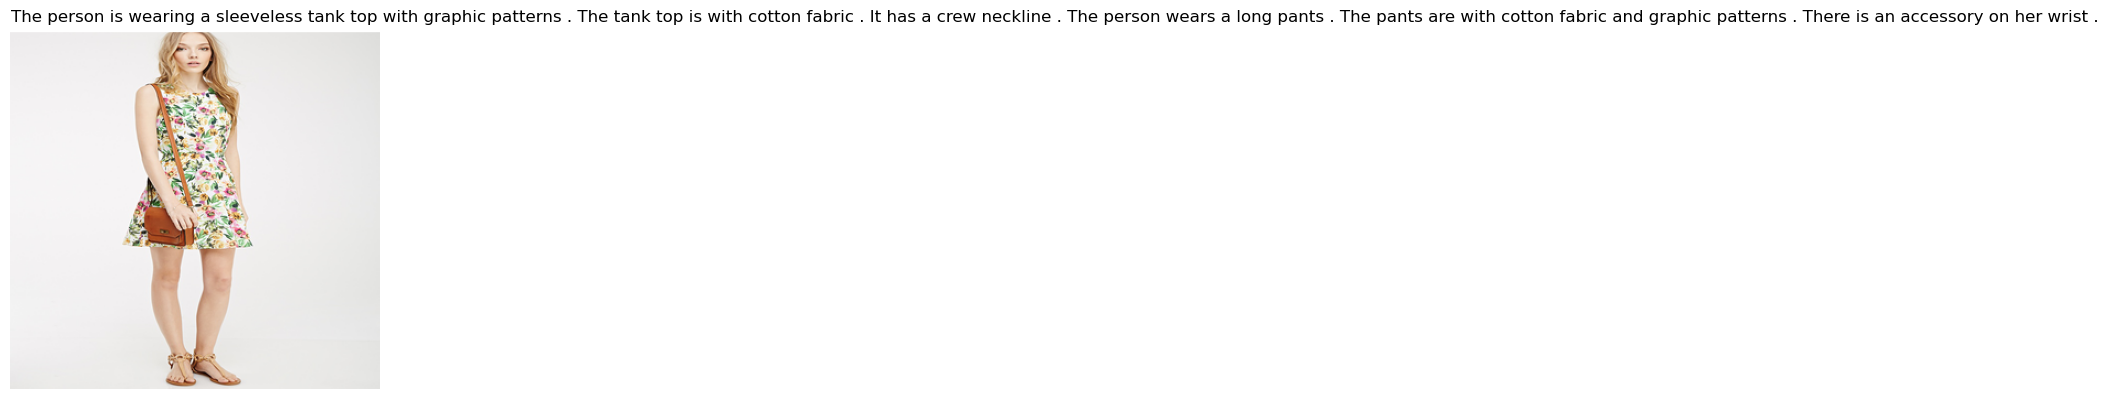

In [64]:
visualize(image_path, seq, rev_word_map)

六、实验结果分析

In [1]:
from api import translate
translate("The person is wearing a sleeveless tank top with graphic patterns . The tank top is with cotton fabric . It has a crew neckline . The person wears a long pants . The pants are with cotton fabric and graphic patterns . There is an accessory on her wrist .")

'此人穿着带有图案的无袖背心。背心是棉布的。它有一个圆领。这个人穿着长裤。这条裤子采用棉布和图案。她的手腕上有一个配件。'


1、输出分析

模型输出结果为此人穿着带有图案的无袖背心。背心是棉布的。它有一个圆领。这个人穿着长裤。这条裤子采用棉布和图案。她的手腕上有一个配件。
而实际图像是这个人穿着带有图案的无袖短款连衣裙裙，裙子是棉布的，它有一个圆领。她的肩上挂着一个斜挎包。

（1）贴合点：无袖 带有图案 棉布 圆领 女士

（2）不足之处及分析：

①误将连衣裙解释为无袖背心加裤子： 模型在对图像进行描述时将连衣裙错误地解释为无袖背心加裤子。这可能是因为两者在结构上有相似之处，模型在生成描述时未能准确捕捉到这一细节。

②误将挎包解释为手腕上的配件： 模型将挎包错误地解释为手腕上的配件，可能是由于挎包在图像中的位置接近手腕，导致模型混淆。
部分描述不准确： 模型的一些描述（如“长裤”）在图像中并不存在，这表明模型在细节上存在一些不准确的生成。

分析：

①结构相似性： 误将连衣裙解释为无袖背心加裤子可能是因为这两者在外观上存在一定的相似性，模型未能捕捉到连衣裙的整体结构。

②位置关系混淆： 挎包被错误地解释为手腕上的配件可能是由于模型未能准确识别物体的位置关系，导致混淆。

③数据不足： 模型的训练数据集可能不足以涵盖各种服装和配饰的多样性，导致模型在某些情况下无法正确理解图像。

总得来说，该模型有一定的准确率，能够有一定逻辑地产出描述图像的语句。

但同时也存在一定误差，造成这种情况的原因是模型训练数据集的数量不够，超参数的设置（如学习率，批量大小，丢弃率，梯度裁剪的阈值，正则化参数等）有待优化，训练迭代次数可以进一步加大，以便进一步优化交叉熵损失函数，提高模型准确率。

2、改进方向：

（1）增加数据： 扩大训练数据集，确保模型能够学习到更多服装和配饰的样式和细节。

（2）优化超参数： 通过系统的超参数调优，包括学习率、批量大小、丢弃率等，优化模型的性能。

（3）改进模型结构： 考虑使用更先进的模型结构，如更复杂的注意力机制或多模态融合模型，以提高模型的描述能力和准确性。

（4）增加训练迭代次数： 增加训练迭代次数，以更好地优化模型参数，提高模型性能。


七、总结


1、总结：

该模型在图像描述生成任务中表现出一定的准确性和逻辑性，能够生成对图像内容有一定解释的语句。然而，在具体细节的捕捉和一些特殊情况的处理上还存在一些不足之处，主要体现在对服装和配饰的误解。这些不足主要由于训练数据不足、模型结构限制以及超参数未经过深度调优等原因导致。

2、创新展望：

（1）多模态信息融合： 引入更多的多模态信息，如图像特征、语音特征等，进行更全面的信息融合，以提高模型对复杂场景的理解能力。

（2）引入语境信息： 融合上下文信息，使模型更好地理解图像描述任务中的语境，从而生成更连贯和合理的描述。

（3）对抗训练： 引入对抗训练机制，通过生成对抗样本来提高模型的鲁棒性和泛化能力，减少对特定样本的过拟合。

（4）交互式学习： 在模型训练中引入用户反馈，通过用户反馈进行模型调整，提高模型的个性化和用户满意度。
